In [1]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.tiny_image_net_data_module import TinyImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [2]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [3]:
data_dir = "data"

dm = TinyImageNetDataModule(
    data_dir=os.path.join(data_dir, "tiny-imagenet-200"), 
    batch_size_train=512,
    batch_size_val=512,
    batch_size_test=512,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [7]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True)

## Or load it from a checkpoint

In [14]:
# model = ContextEncoder.load_from_checkpoint("checkpoints/tiny_imagenet/2024-12-16_14-34-46-epoch=76-val_loss=0.32.ckpt") # change the path to your checkpoint
# model.enable_save_image_per_epoch()
# model.to("cuda")

ContextEncoder(
  (psnr_metric): PeakSignalNoiseRatio()
  (joint_loss): JointLoss(
    (rec_loss): ReconstructionLoss()
    (adv_loss): AdversarialLoss(
      (loss_function): BCELoss()
    )
  )
  (rec_loss): ReconstructionLoss()
  (adv_loss): AdversarialLoss(
    (loss_function): BCELoss()
  )
  (generator): AdversarialGenerator(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2

## Train it

In [9]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/tiny_imagenet',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | psnr_metric   | PeakSignalNoiseRatio     | 0      | train
1 | joint_loss    | JointLoss                | 0      | train
2 | rec_loss      | ReconstructionLoss       | 0      | train
3 | adv_loss      | AdversarialLoss          | 0      | train
4 | generator     | AdversarialGenerator     | 71.1 M | train
5 | discriminator | AdversarialDiscriminator | 2.8 M  | train
-------------------------------------------------------------------
73.9 M    Trainable params
0         Non-trainable params
73.9 M    Total params
295.556   Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Epoch 100:   2%|▏         | 4/196 [00:03<02:45,  1.16it/s, v_num=0, train_psnr=22.20, train_loss_context_encoder=0.061, train_loss_discriminator=0.00743, val_psnr=14.90, val_loss=0.328]   


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Display some images and evaluate the model performances

Here the results of this cell are after 100 epochs on the Tiny Image Net dataset (10x less images compared to Image Net) in 64x64

- **Number of steps**: 19 599
- **Time**: 3h45
- **Observation (with tensorboard)**: Note that this dataset is quite small compared to the full Image Net, we have 100 000 images. We can clearly see the overfitting after step 2 000 (after around 23 min, around epoch 10). So in this cell we will plot the last epoch and then in the following one we will plot the epoch with the best validation score.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           14.809653282165527
        test_loss            0.339731901884079
        test_psnr           14.813262939453125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0:  37%|███▋      | 72/196 [3:59:28<6:52:26,  0.01it/s, v_num=0, train_psnr=13.70, train_loss_context_encoder=0.638, train_loss_discriminator=0.00744]


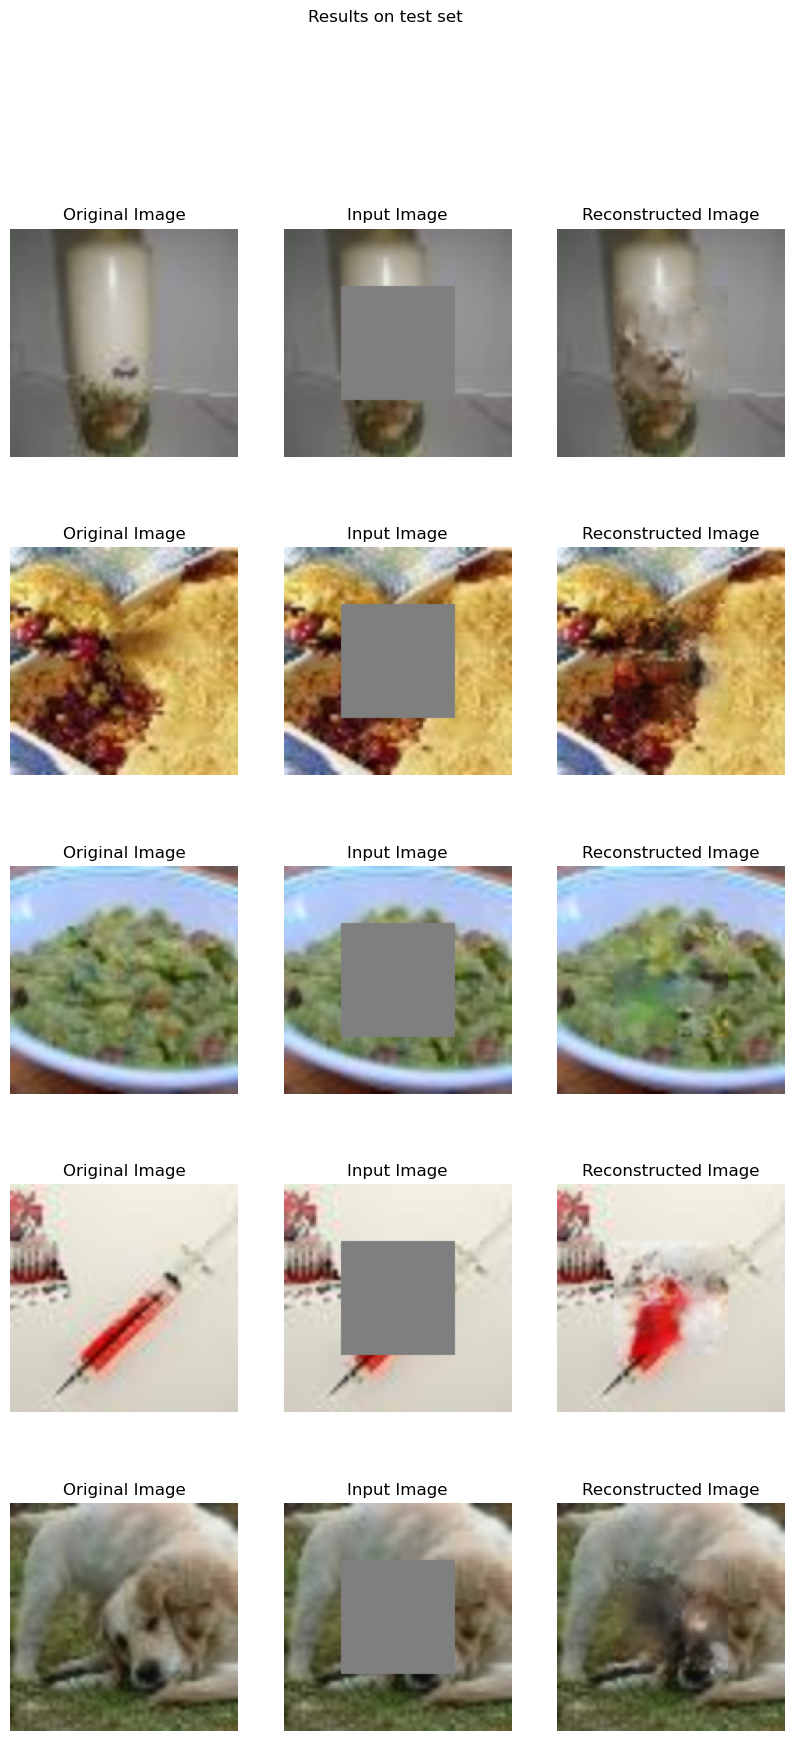

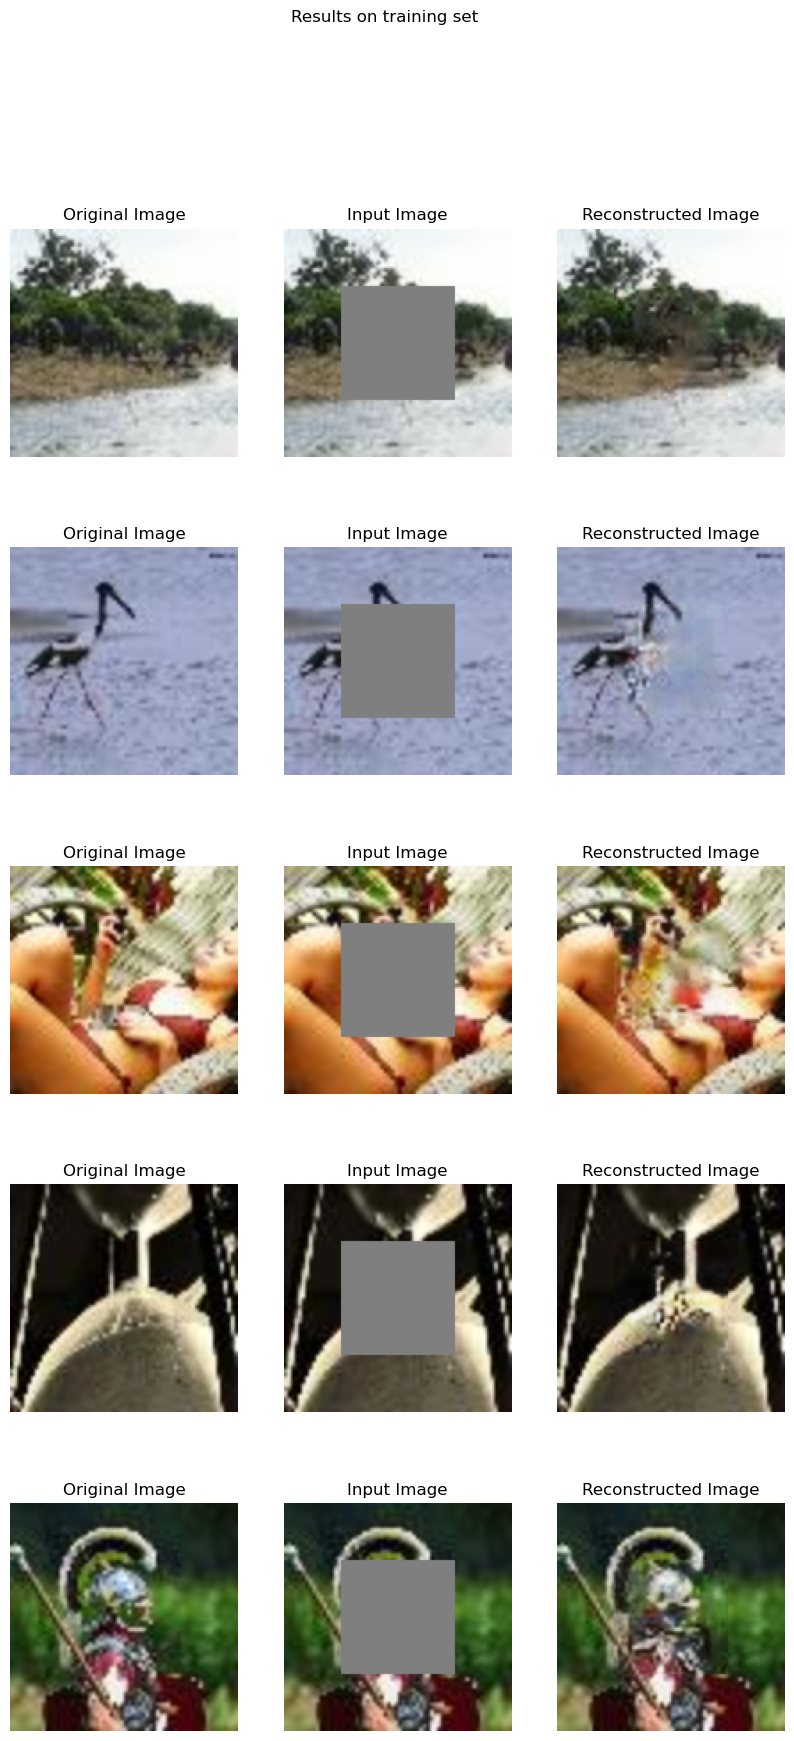

In [11]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

## Results on the best validation loss model

Here the results of this cell are after 10 epochs on the Tiny Image Net dataset (10x less images compared to Image Net) in 64x64.

- **Number of steps**: around 2 000
- **Time**: around 20min

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           15.962298393249512
        test_loss           0.29222244024276733
        test_psnr            15.96678638458252
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


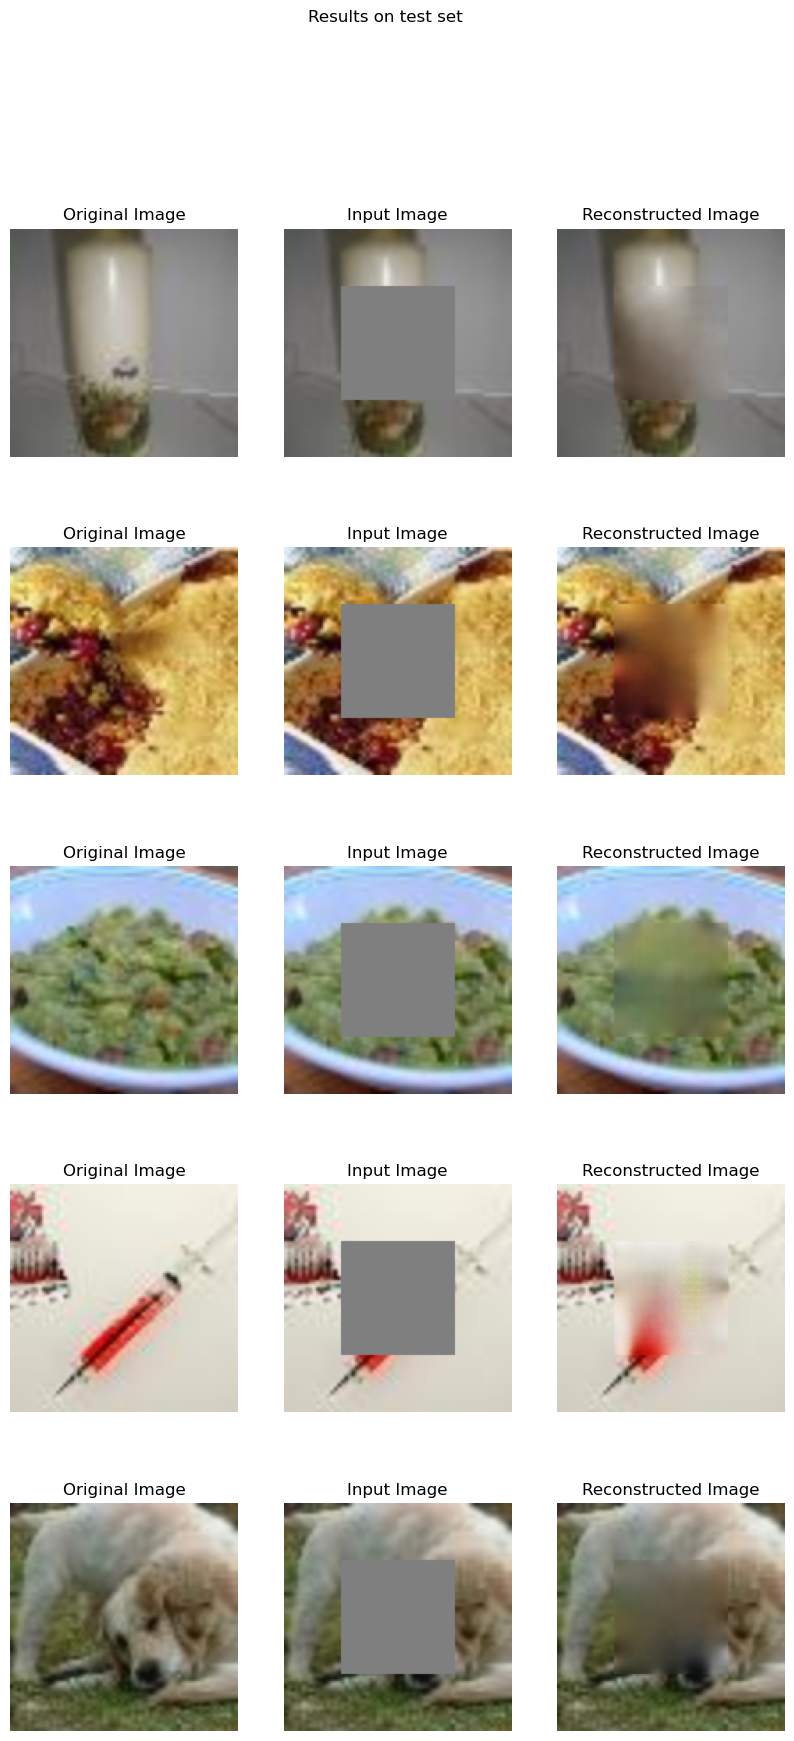

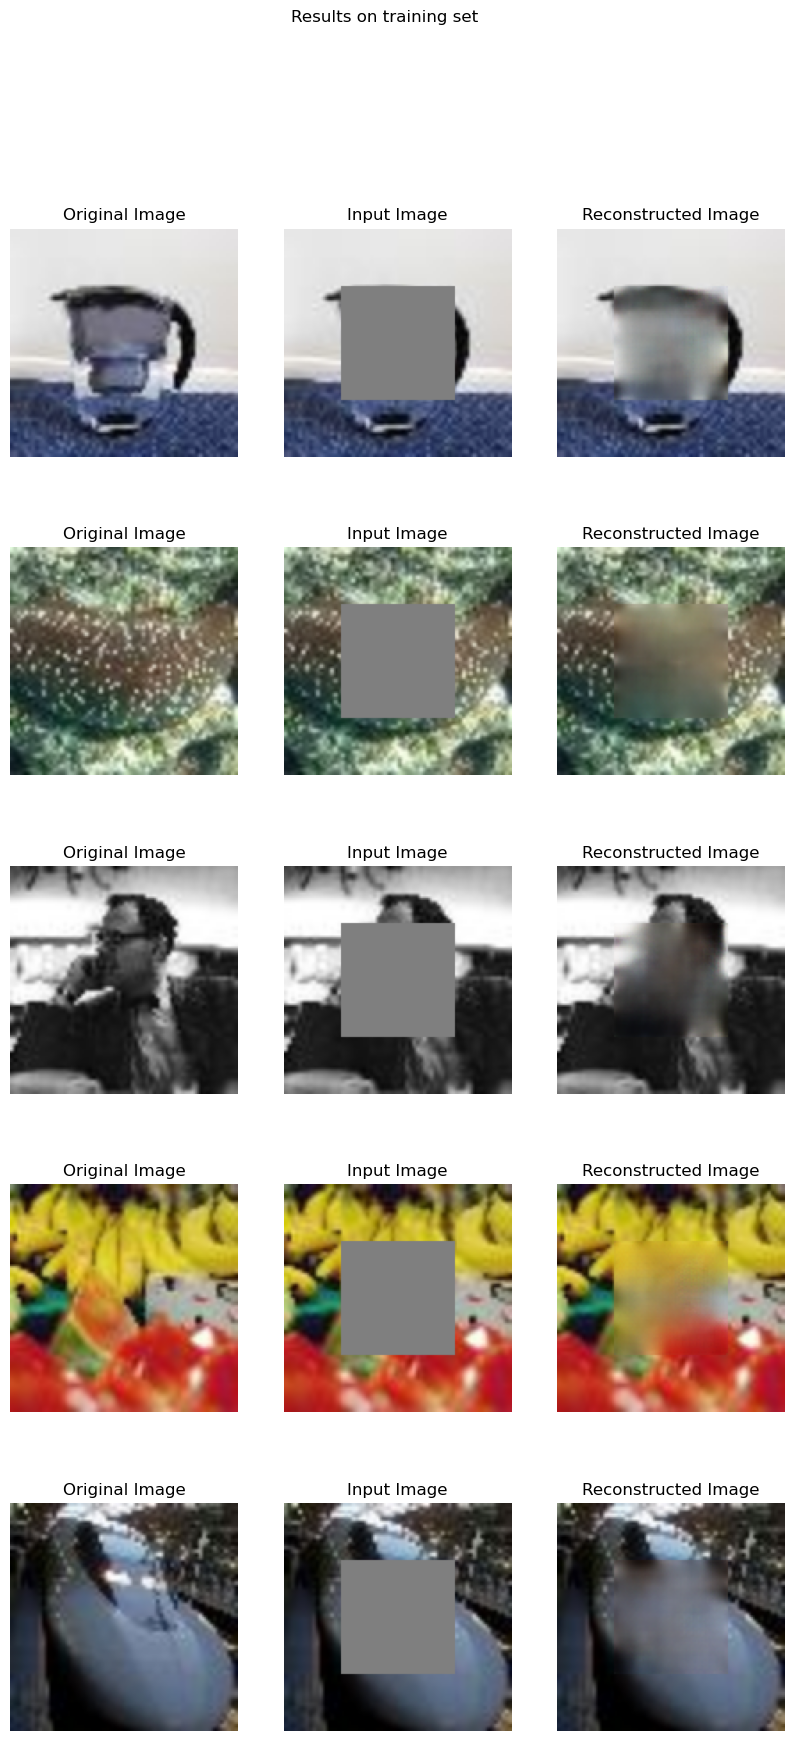

In [13]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

## Comparison

The first epochs are still blurry, so even if the loss is lower, the results is actually less realistic. On the other hand the last epoch is less blurry there is still some noise. It's especially visible in the logged image (validation set) that are not displayed here but that you can find using the tensorboard notebook and the GIF create_output_per_epoch_animated_result notebook.

The other tests (other notebooks) will try with a bigger dataset (Image Net) and with different parameters on Tiny Image Net